# System for Pollen Identification
***
By Ryder Mitchell

> Hello! This is my system for processing data and augmenting it, and using transfer learning to train a model to classify types of pollen grains. This notebook will be documented and littered with comments so as to alleviate any confusion and aid in ease of use!

> The first step of this process is to make sure the "AlteredPollenSlides" is present in the same directory as this folder. The AlteredPollenSlides contains an organized list of pollen slides from the Pollen Slides dataset without any subfolders or any other files. This will make adding pollen types and detecting pollen grains easier.
<br>
There is the Minnesota Pollen Images dataset available, but I have chosen not to use this due to the complexity of the dataset and differences to the dataset given. If one would like to use the Minnesota Pollen Images in transfer learning, simply drop in any pollen slides to their corresponding folders inside "AlteredPollenSlides"

> If new pollen slides are to be added, simply put them inside a folder named after the pollen type, and drop it into the AlteredPollenSlides folder! If any pollen slides need to be added to existing pollen types, drop those slides into the already existing folder! 

In [20]:
# This cell will import all necessary libraries. We use Pytorch to train the model.


#Libraries used in data augmentation
import cv2
import numpy as np
import os
import PIL
from IPython.display import Image, display
from matplotlib import pyplot as plt
import math
from pathlib import Path
import shutil
import random
import time

#Libraries used in training
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import copy

> This cell below creates the parameters for detecting pollen grains using opencv2's blob detection. These are the parameters I found to work best, but feel free to change these however you'd like!
<br>
An explanation for what each parameter does can be found __[here](https://learnopencv.com/blob-detection-using-opencv-python-c/)__.

In [21]:
# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()

# Change thresholds
# params.filterByThreshold = True

params.minThreshold = 150;
params.maxThreshold = 256;

params.filterByColor = False

# Filter by Area.
params.filterByArea = True
params.minArea = 20000
params.maxArea = 5000000

# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.1

# Filter by Convexity
params.filterByConvexity = False
params.minConvexity = 0.87

# Filter by Inertia
params.filterByInertia = False
params.minInertiaRatio = 0.01

detector = cv2.SimpleBlobDetector_create(params)


> Below this are the data augmentation functions and their usage. Feel free to add more here, following the format shown. The functions and more functions you can use can be found here __[here](https://towardsdatascience.com/complete-image-augmentation-in-opencv-31a6b02694f5)__.

In [22]:
# Vertical shift

def fill(img, h, w):
    img = cv2.resize(img, (h, w), cv2.INTER_CUBIC)
    return img
def vertical_shift(img, ratio=0.0):
    if ratio > 1 or ratio < 0:
        print('Value should be less than 1 and greater than 0')
        return img
    ratio = random.uniform(-ratio, ratio)
    h, w = img.shape[:2]
    to_shift = h*ratio
    if ratio > 0:
        img = img[:int(h-to_shift), :, :]
    if ratio < 0:
        img = img[int(-1*to_shift):, :, :]
    img = fill(img, h, w)
    return img
# img = vertical_shift(img, 0.7)

In [23]:
# Horizontal Shift

def fill(img, h, w):
    img = cv2.resize(img, (h, w), cv2.INTER_CUBIC)
    return img
        
def horizontal_shift(img, ratio=0.0):
    if ratio > 1 or ratio < 0:
        print('Value should be less than 1 and greater than 0')
        return img
    ratio = random.uniform(-ratio, ratio)
    h, w = img.shape[:2]
    to_shift = w*ratio
    if ratio > 0:
        img = img[:, :int(w-to_shift), :]
    if ratio < 0:
        img = img[:, int(-1*to_shift):, :]
    img = fill(img, h, w)
    return img
# img = horizontal_shift(img, 0.7)

In [24]:
# Brightness

def brightness(img, low, high):
    value = random.uniform(low, high)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype = np.float64)
    hsv[:,:,1] = hsv[:,:,1]*value
    hsv[:,:,1][hsv[:,:,1]>255]  = 255
    hsv[:,:,2] = hsv[:,:,2]*value 
    hsv[:,:,2][hsv[:,:,2]>255]  = 255
    hsv = np.array(hsv, dtype = np.uint8)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return img
# img = brightness(img, 0.5, 3)

In [25]:
# Channel Shift

def channel_shift(img, value):
    value = int(random.uniform(-value, value))
    img = img + value
    img[:,:,:][img[:,:,:]>255]  = 255
    img[:,:,:][img[:,:,:]<0]  = 0
    img = img.astype(np.uint8)
    return img
# img = channel_shift(img, 60)

> Below this are the image processing steps. To summarize what this cell does, it iterates through each folder inside AlteredPollenSlides and iterates through each image inside, detecting keypoints in each image. These keypoints are then passed through filters to determine if they contain pollen grains, and if they do, are then randomly selected to be in the training or validation parts of the dataset. I found these parameters to work best, but feel free to change them to how you see fit!

In [26]:

# List of files contained in the directory AlteredPollenSlides
newAllFiles = (list(os.walk(".\\AlteredPollenSlides")))

# Creating the folder directory for training and validation data. If this already exists, we delete all folders
    # And files inside it, as we don't want old data being mixed with new data.
trainingAndValidation = ".\\trainingAndValidation"
if os.path.exists(trainingAndValidation) and os.path.isdir(trainingAndValidation):
    shutil.rmtree(trainingAndValidation)
os.makedirs(trainingAndValidation) 
trainingDestination = ".\\trainingAndValidation\\train"
validationDestination = ".\\trainingAndValidation\\val"
os.makedirs(trainingDestination) 
os.makedirs(validationDestination) 


# For every folder in the AlteredPollenSlides folder,
for i in range(len(newAllFiles[0][1])):
    numberOfImages = 0
    totalNumberOfImages = 0
    
    # Get the folder/pollen name, and create the directories for training and validation data for this specific pollen type.
    folderClassification = newAllFiles[0][1][i]
    folderDirectory = os.path.join(".\\AlteredPollenSlides\\", newAllFiles[0][1][i])
    specificPollenTrainingDestination = os.path.join(trainingDestination, newAllFiles[0][1][i])
    specificPollenValidationDestination = os.path.join(validationDestination, newAllFiles[0][1][i])
    os.makedirs(specificPollenTrainingDestination) 
    os.makedirs(specificPollenValidationDestination) 
    
    # Get the number of images inside the pollen's folder inside AlteredPollenSlides.
    listOfFiles = ((list(os.walk(folderDirectory)))[0])[2]
    
    # Simply to keep track of progress
    print(int((i/len(newAllFiles[0][1]))*100), " percent complete.")
    
    
    
    # For each image,
    for j in range(len(listOfFiles)):
        
        # Create variables for the file's path, read in the image using opencv2, and convert it to grayscale.
        inputImageDirectory = os.path.join(folderDirectory, listOfFiles[j])
        currentImage = cv2.imread(inputImageDirectory)
        currentImageGray = cv2.cvtColor(cv2.imread(inputImageDirectory), cv2.COLOR_BGR2GRAY)
        
        # Get the width and height, and rgb values of the image. 
        width, height, imNotSureLol = currentImage.shape
        b1, g1, r1 = currentImage[width-1, height-1]        
        
        # Detect any keypoints using the parameters defined in a cell earlier.
        keypoints = detector.detect(currentImage)
        
        # This line is used for debug purposes, in case the cell throws an error on a specific image, you can view the
            # output.
        imgKeyPoints = cv2.drawKeypoints(currentImage, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        cv2.imwrite("keyPoints.jpg", imgKeyPoints)
        
        # For every keypoint in our image, 
        for k in range(len(keypoints)):

            # Get the dimensions and coordinates of the keypoint.
            x1, y1 = keypoints[k].pt
            x1 = int(x1)
            y1 = int(y1)
            size = int(keypoints[k].size)
            size1 = int(size/2)
  
            # Create a crop based on these values.
            crop = currentImage[y1-size1:y1+size1, x1-size1:x1+size1]
            cropHeight, cropWidth, cropidklol = crop.shape
        
            # Because the keypoints are defined using circles, if the crop height and width are not equal, it must be off screen.
                # Therefore, we don't want this data inside our training dataset.
            if(cropHeight != cropWidth):
                pass
            # If the keypoints have a height or width of 0, something is clearly wrong and we don't want it.
            elif ((cropHeight == 0) | (cropWidth == 0)):
                pass
            else:
                
                # Get the average rgb values contained in this crop.
                b2, g2, r2 = cv2.split(crop)
                newAverage = np.average(crop)
                bAverage = np.average(b2)
                gAverage = np.average(g2)
                rAverage = np.average(r2)
                
                # If the crop's average pixel content is close enough to white, we discard it. We don't want the training dataset
                    # To include images of the background or anything not a pollen grain.
                    # Fell free to adjust these how you see fit if they are insufficient!
                if((newAverage > 225) & (bAverage > 210) & (rAverage > 210) & (gAverage > 210)):
                        pass
                    
                # This else statement dictates if the crop has been determined to contain a pollen grain.
                else:
                    
                    # A random number is chosen to determine whether the image will belong to the training set or validation
                        # set. Feel free to adjust the numbers as you see fit! I found 4 to be a nice balance.
                        # A number higher than 4 will increase the chance the image is added to the validation set, and a lower
                        # number will increase the chance the image is added to the training dataset.
                    if(random.uniform(0, 10) < 3):
                        
                        # The image is then saved to it's corresponding validation path in the trainingAndValidation folder.
                        imageName = str(numberOfImages) + ".jpg"
                        savedCropPath = os.path.join(specificPollenValidationDestination, imageName)
                        cv2.imwrite(savedCropPath, crop)
                        numberOfImages = numberOfImages + 1
                        totalNumberOfImages = totalNumberOfImages + 1
                        
                    # If the random number generator chooses a number greater than the validation chance, then the image is
                        # Being added to the training set.
                        # However, due to the low number of images in the dataset, a data augmentation step also occurs here.
                        # Feel free to add any steps based on the format here and in the previous data augmentation functions
                        # earlier!
                    else:
                        imageName = str(numberOfImages) + ".jpg"
                        savedCropPath = os.path.join(specificPollenTrainingDestination, imageName)
                        cv2.imwrite(savedCropPath, crop)
                        numberOfImages = numberOfImages + 1
                        totalNumberOfImages = totalNumberOfImages + 1
                        
                        # The data augmentation is done in a set of loops. Currently a range of 4 will result in 16 augmented
                            # images for every 1 unaltered image in the training set. However, feel free to adjust this number
                            # to how you see fit!
                        for i in range(3):
                            
                            imageName = str(numberOfImages) + ".jpg"
                            savedCropPath = os.path.join(specificPollenTrainingDestination, imageName)
                            cv2.imwrite(savedCropPath, channel_shift(crop, 10))
                            numberOfImages = numberOfImages + 1
                            totalNumberOfImages = totalNumberOfImages + 1

                            imageName = str(numberOfImages) + ".jpg"
                            savedCropPath = os.path.join(specificPollenTrainingDestination, imageName)
                            cv2.imwrite(savedCropPath, brightness(crop, .2, 2.2))
                            numberOfImages = numberOfImages + 1
                            totalNumberOfImages = totalNumberOfImages + 1

                            imageName = str(numberOfImages) + ".jpg"
                            savedCropPath = os.path.join(specificPollenTrainingDestination, imageName)
                            cv2.imwrite(savedCropPath, horizontal_shift(crop, .7))
                            numberOfImages = numberOfImages + 1
                            totalNumberOfImages = totalNumberOfImages + 1

                            imageName = str(numberOfImages) + ".jpg"
                            savedCropPath = os.path.join(specificPollenTrainingDestination, imageName)
                            cv2.imwrite(savedCropPath, vertical_shift(crop, .7))
                            numberOfImages = numberOfImages + 1
                            totalNumberOfImages = totalNumberOfImages + 1
                            

                        
                        
# Done! 
print("Done!")

0  percent complete.
4  percent complete.
8  percent complete.
13  percent complete.
17  percent complete.
21  percent complete.
26  percent complete.
30  percent complete.
34  percent complete.
39  percent complete.
43  percent complete.
47  percent complete.
52  percent complete.
56  percent complete.
60  percent complete.
65  percent complete.
69  percent complete.
73  percent complete.
78  percent complete.
82  percent complete.
86  percent complete.
91  percent complete.
95  percent complete.
Done!


> The steps below indicate the start of the neural net process and using transfer learning on our augmented data.
<br>
Much of the code is adapted from professor Wloka's transfer learning demo.

In [27]:
# Simply checks if cuda hardware acceleration is available. 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

print(torch.__version__)

True
1.8.2+cu111


In [28]:
# Create the classes and dataloaders.

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'trainingAndValidation'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [29]:
print('Classes are:')
print(class_names)
print(' ')
print('The amount of data is:')
print(dataset_sizes)
print(' ')
print('The dataset dictionary is:')
print(image_datasets)

Classes are:
['Acmispon glaber', 'Amsinckia intermedia', 'Calystegia macrostegia', 'Camissonia bistorta', 'Centaurea melitensis', 'Corethrogyne filaginifolia', 'Croton setigerus', 'Ericameria pinifolia', 'Eriogonum fasciculatum', 'Eriogonum gracile', 'Erodium Botrys', 'Erodium cicutarium', 'Heterotheca grandiflora', 'Hirschfeldia incana', 'Lepidospartum squamatum', 'Lessingia glandulifera', 'Marah Macrocarpa', 'Mirabilis laevis', 'Penstemon spectabilis', 'Phacelia distans', 'Ribes aureum', 'Salvia apiana', 'Solanum umbelliferum']
 
The amount of data is:
{'train': 54285, 'val': 522}
 
The dataset dictionary is:
{'train': Dataset ImageFolder
    Number of datapoints: 54285
    Root location: trainingAndValidation\train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0

In [30]:
def tensor_show(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

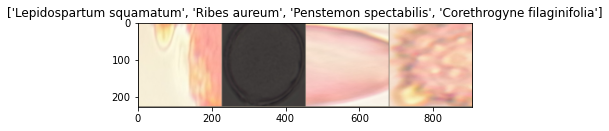

In [31]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

tensor_show(out, title=[class_names[x] for x in classes])

In [32]:
# Function for training the model.
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [33]:
# Function for visualizing the model outputs
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                tensor_show(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [36]:
# Creating parameters for performing transfer learning.
# While resnet18 offered decent accuracy, I tried to experiment
    # with other models such as efficientnet_b7 and inception.
    # I also tried to experiment with other loss functions, but
    # unfortunately could not get them to work. However, I
    # would expect efficientnet_b7 to yield greater results!

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [37]:
# Function for using transfer learning on the model
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=24)

Epoch 0/23
----------
train Loss: 1.9216 Acc: 0.4618
val Loss: 1.0887 Acc: 0.7146

Epoch 1/23
----------
train Loss: 1.8044 Acc: 0.5097
val Loss: 0.9102 Acc: 0.7720

Epoch 2/23
----------
train Loss: 1.7942 Acc: 0.5186
val Loss: 1.0872 Acc: 0.7414

Epoch 3/23
----------
train Loss: 1.7876 Acc: 0.5222
val Loss: 0.8081 Acc: 0.7931

Epoch 4/23
----------
train Loss: 1.7854 Acc: 0.5245
val Loss: 0.9840 Acc: 0.7605

Epoch 5/23
----------
train Loss: 1.7843 Acc: 0.5261
val Loss: 0.9253 Acc: 0.7663

Epoch 6/23
----------


KeyboardInterrupt: 

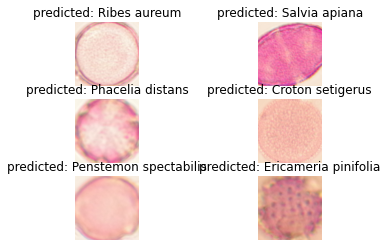

In [17]:
# Visualizing the model outputted
visualize_model(model_conv)

In [18]:
# If these results are satisfactory, save the model and it's weights!
torch.save(model_conv, 'pollenIdentificationModel.pth')